# Checking out the data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%load_ext tensorboard

In [3]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

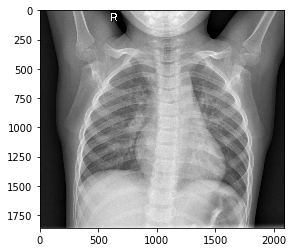

In [4]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img,cmap='gray')
plt.show()

In [5]:
import os
def plot_images(path, labeled=False, max_images=6):
    amount = 0
    fig = plt.figure(figsize=(12, 6))

    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            if amount == max_images:
                break
            img = mpimg.imread(os.path.join(path, file))
            plt.subplot(231+amount)
            if labeled:
                plt.title(file.split('_')[1])
            imgplot = plt.imshow(img,cmap='gray')
            amount += 1

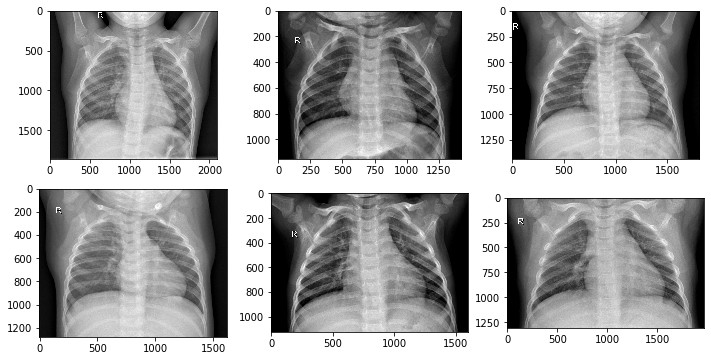

In [6]:
plot_images(training_dir + '/NORMAL')

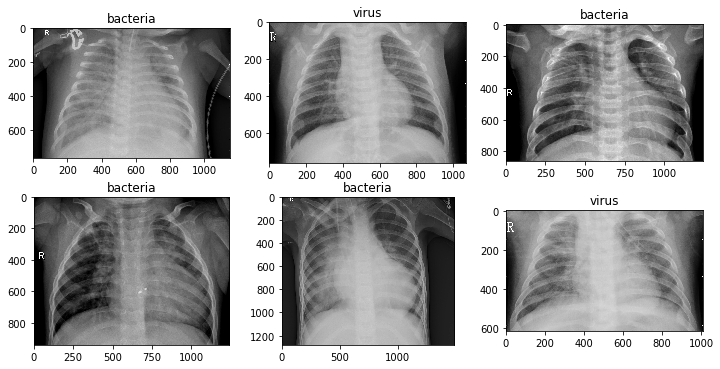

In [7]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

# Train the model

In [8]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

In [10]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

Found 5216 images belonging to 2 classes.


In [11]:
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

Found 624 images belonging to 2 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 16 images belonging to 2 classes.


In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SeparableConv2D, BatchNormalization, Dropout

def InceptionV3_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
    x = tensorflow.keras.layers.Dense(1024, activation='relu')(x)
    x = tensorflow.keras.layers.BatchNormalization()(x)
    predictions = tensorflow.keras.layers.Dense(2, activation='softmax')(x)
    model = tensorflow.keras.models.Model(inputs=base_model.inputs, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.summary()
    return model

def VGG16_model():
    NUM_CLASSES = 2
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    x = base_model.output
    x = tensorflow.keras.layers.Flatten()(x)
    x = tensorflow.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tensorflow.keras.models.Model(inputs=base_model.input, outputs=x)
    model.summary()
    return model

def MyModel():
    IMG_SIZE = (150, 150, 3)
    inputs = tensorflow.keras.layers.Input(shape=IMG_SIZE)
    
    # First conv block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second conv block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Third conv block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Fourth conv block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # Fifth conv block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # FC layer
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.7)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)

    # Output layer
    output = Dense(2, activation='softmax')(x)
    model = tensorflow.keras.models.Model(inputs=inputs, outputs=output)
    model.summary()
    return model

# InceptionV3_model 

In [14]:
model = InceptionV3_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpoint = ModelCheckpoint(filepath='best_weights_InceptionV3_model.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.251, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

 
model.compile(optimizer=tensorflow.keras.optimizers.Adam(0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 200,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks=[checkpoint, lr_reduce]
)

Epoch 1/200
163/163 [==============================] - 114s 700ms/step - loss: 0.7110 - accuracy: 0.6660 - val_loss: 3.4282 - val_accuracy: 0.3814
Epoch 2/200
163/163 [==============================] - 88s 540ms/step - loss: 0.5534 - accuracy: 0.7521 - val_loss: 3.1033 - val_accuracy: 0.4038
Epoch 3/200
162/163 [============================>.] - ETA: 0s - loss: 0.5016 - accuracy: 0.7865
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.5099999365920666e-06.
163/163 [==============================] - 87s 535ms/step - loss: 0.5009 - accuracy: 0.7866 - val_loss: 1.6817 - val_accuracy: 0.5978
Epoch 4/200
163/163 [==============================] - 87s 532ms/step - loss: 0.4619 - accuracy: 0.8046 - val_loss: 2.1740 - val_accuracy: 0.5801
Epoch 5/200
162/163 [============================>.] - ETA: 0s - loss: 0.4548 - accuracy: 0.8173
Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.30009957603761e-07.
163/163 [==============================] - 87s 533ms/step - loss: 0.4560 

Epoch 38/200
163/163 [==============================] - 87s 531ms/step - loss: 0.4515 - accuracy: 0.8160 - val_loss: 2.4430 - val_accuracy: 0.5641
Epoch 39/200
162/163 [============================>.] - ETA: 0s - loss: 0.4567 - accuracy: 0.8098
Epoch 00039: ReduceLROnPlateau reducing learning rate to 3.9246474367736184e-17.
163/163 [==============================] - 87s 531ms/step - loss: 0.4569 - accuracy: 0.8100 - val_loss: 2.4517 - val_accuracy: 0.5609
Epoch 40/200
163/163 [==============================] - 87s 532ms/step - loss: 0.4491 - accuracy: 0.8140 - val_loss: 2.4264 - val_accuracy: 0.5657
Epoch 41/200
162/163 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.8140
Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.850865026438293e-18.
163/163 [==============================] - 87s 533ms/step - loss: 0.4512 - accuracy: 0.8140 - val_loss: 2.3613 - val_accuracy: 0.5705
Epoch 42/200
163/163 [==============================] - 88s 541ms/step - loss: 0.

Epoch 74/200
163/163 [==============================] - 87s 532ms/step - loss: 0.4480 - accuracy: 0.8165 - val_loss: 2.5494 - val_accuracy: 0.5513
Epoch 75/200
162/163 [============================>.] - ETA: 0s - loss: 0.4355 - accuracy: 0.8200
Epoch 00075: ReduceLROnPlateau reducing learning rate to 6.136597199296339e-28.
163/163 [==============================] - 86s 530ms/step - loss: 0.4363 - accuracy: 0.8196 - val_loss: 2.4482 - val_accuracy: 0.5609
Epoch 76/200
163/163 [==============================] - 87s 534ms/step - loss: 0.4497 - accuracy: 0.8171 - val_loss: 2.3170 - val_accuracy: 0.5705
Epoch 77/200
162/163 [============================>.] - ETA: 0s - loss: 0.4509 - accuracy: 0.8127
Epoch 00077: ReduceLROnPlateau reducing learning rate to 1.5402859279615197e-28.
163/163 [==============================] - 88s 539ms/step - loss: 0.4499 - accuracy: 0.8127 - val_loss: 2.4437 - val_accuracy: 0.5673
Epoch 78/200
163/163 [==============================] - 87s 535ms/step - loss: 0.

Epoch 110/200
163/163 [==============================] - 87s 531ms/step - loss: 0.4527 - accuracy: 0.8089 - val_loss: 2.4354 - val_accuracy: 0.5673
Epoch 111/200
162/163 [============================>.] - ETA: 0s - loss: 0.4503 - accuracy: 0.8140
Epoch 00111: ReduceLROnPlateau reducing learning rate to 9.595213087390415e-39.
163/163 [==============================] - 86s 530ms/step - loss: 0.4504 - accuracy: 0.8144 - val_loss: 2.4541 - val_accuracy: 0.5593
Epoch 112/200
163/163 [==============================] - 87s 531ms/step - loss: 0.4477 - accuracy: 0.8119 - val_loss: 2.3393 - val_accuracy: 0.5673
Epoch 113/200
162/163 [============================>.] - ETA: 0s - loss: 0.4528 - accuracy: 0.8152
Epoch 00113: ReduceLROnPlateau reducing learning rate to 2.408398530659363e-39.
163/163 [==============================] - 88s 541ms/step - loss: 0.4517 - accuracy: 0.8156 - val_loss: 2.4406 - val_accuracy: 0.5609
Epoch 114/200
163/163 [==============================] - 86s 529ms/step - loss

Epoch 150/200
163/163 [==============================] - 86s 530ms/step - loss: 0.4479 - accuracy: 0.8133 - val_loss: 2.4901 - val_accuracy: 0.5625
Epoch 151/200
163/163 [==============================] - 86s 531ms/step - loss: 0.4384 - accuracy: 0.8123 - val_loss: 2.4497 - val_accuracy: 0.5609
Epoch 152/200
163/163 [==============================] - 87s 532ms/step - loss: 0.4530 - accuracy: 0.8135 - val_loss: 2.4935 - val_accuracy: 0.5561
Epoch 153/200
163/163 [==============================] - 88s 539ms/step - loss: 0.4469 - accuracy: 0.8171 - val_loss: 2.3161 - val_accuracy: 0.5753
Epoch 154/200
163/163 [==============================] - 86s 530ms/step - loss: 0.4629 - accuracy: 0.8131 - val_loss: 2.4125 - val_accuracy: 0.5673
Epoch 155/200
163/163 [==============================] - 86s 529ms/step - loss: 0.4407 - accuracy: 0.8204 - val_loss: 2.3441 - val_accuracy: 0.5769
Epoch 156/200
163/163 [==============================] - 87s 533ms/step - loss: 0.4537 - accuracy: 0.8150 - val_

In [17]:
model.save("finalInceptionV3_final.h5")
print("Saved model to disk")

Saved model to disk


## Evaluate the model

In [18]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 2s 112ms/step - loss: 2.5784 - accuracy: 0.5000
Loss: 2.5783678111503345
Accuracy: 0.5


In [19]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
    y_img_batch, y_true_batch = test_generator[i]
    y_true_batch = y_true_batch.argmax(axis=-1)
    y_img_batches.append(y_img_batch)
    y_true_batches.append(y_true_batch)

    y_pred_batch = model.predict(y_img_batch)
    y_pred_batch = y_pred_batch.argmax(axis=-1)
    y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64)]

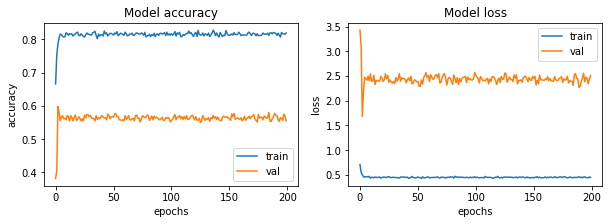

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [21]:
def predict_images(images_path, label):
    amount = 0
    fig = plt.figure(figsize=(18, 8))

    for file in os.listdir(images_path):
        if file.endswith('.jpeg'):
            if amount == 8:
                break
            img = mpimg.imread(os.path.join(images_path, file))
            plt.subplot(241+amount)
            plt.title('Actual:{}\nPredicted:{}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
            imgplot = plt.imshow(img, cmap="gray")

            amount += 1

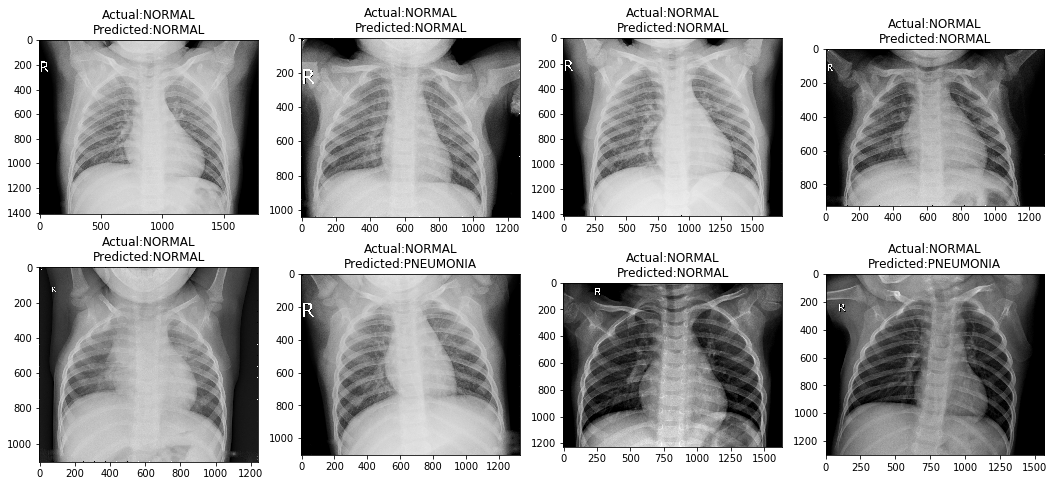

In [22]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

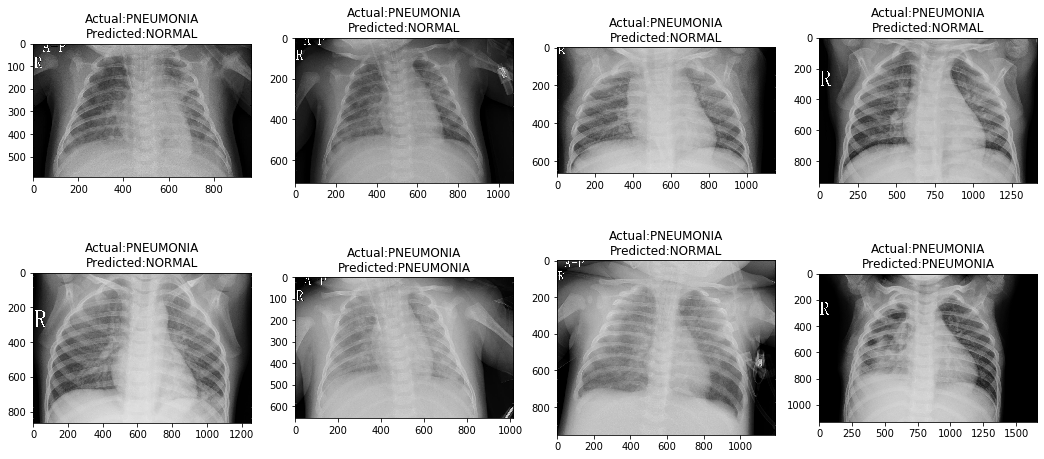

In [23]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

# VGG16_model 

In [24]:
model = VGG16_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpoint = ModelCheckpoint(filepath='best_weights_VGG16_model.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

 
model.compile(optimizer=tensorflow.keras.optimizers.Adam(0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 200,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks=[checkpoint, lr_reduce]
)

Epoch 1/200
163/163 [==============================] - 84s 514ms/step - loss: 0.1872 - accuracy: 0.9273 - val_loss: 0.2317 - val_accuracy: 0.9151
Epoch 2/200
163/163 [==============================] - 79s 483ms/step - loss: 0.1158 - accuracy: 0.9588 - val_loss: 0.3194 - val_accuracy: 0.9022
Epoch 3/200
163/163 [==============================] - 78s 481ms/step - loss: 0.1005 - accuracy: 0.9641 - val_loss: 0.4389 - val_accuracy: 0.8478
Epoch 4/200
163/163 [==============================] - 78s 480ms/step - loss: 0.0958 - accuracy: 0.9634 - val_loss: 0.2173 - val_accuracy: 0.9295
Epoch 5/200
162/163 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9678
Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
163/163 [==============================] - 78s 479ms/step - loss: 0.0820 - accuracy: 0.9680 - val_loss: 0.2246 - val_accuracy: 0.9311
Epoch 6/200
163/163 [==============================] - 78s 480ms/step - loss: 0.0620 - accuracy: 0.9789 

Epoch 38/200
163/163 [==============================] - 78s 478ms/step - loss: 0.0504 - accuracy: 0.9816 - val_loss: 0.2351 - val_accuracy: 0.9311
Epoch 39/200
162/163 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9832
Epoch 00039: ReduceLROnPlateau reducing learning rate to 3.8742047798209866e-15.
163/163 [==============================] - 78s 478ms/step - loss: 0.0469 - accuracy: 0.9827 - val_loss: 0.2286 - val_accuracy: 0.9311
Epoch 40/200
163/163 [==============================] - 78s 481ms/step - loss: 0.0481 - accuracy: 0.9849 - val_loss: 0.2240 - val_accuracy: 0.9311
Epoch 41/200
162/163 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9821
Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.1622613831243191e-15.
163/163 [==============================] - 78s 478ms/step - loss: 0.0483 - accuracy: 0.9822 - val_loss: 0.2239 - val_accuracy: 0.9311
Epoch 42/200
163/163 [==============================] - 78s 480ms/step - loss: 0

Epoch 74/200
163/163 [==============================] - 78s 479ms/step - loss: 0.0466 - accuracy: 0.9833 - val_loss: 0.2234 - val_accuracy: 0.9311
Epoch 75/200
162/163 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.9819
Epoch 00075: ReduceLROnPlateau reducing learning rate to 1.5009463961579317e-24.
163/163 [==============================] - 78s 478ms/step - loss: 0.0490 - accuracy: 0.9820 - val_loss: 0.2264 - val_accuracy: 0.9311
Epoch 76/200
163/163 [==============================] - 78s 479ms/step - loss: 0.0490 - accuracy: 0.9820 - val_loss: 0.2268 - val_accuracy: 0.9311
Epoch 77/200
162/163 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9821
Epoch 00077: ReduceLROnPlateau reducing learning rate to 4.502839247638363e-25.
163/163 [==============================] - 78s 479ms/step - loss: 0.0503 - accuracy: 0.9820 - val_loss: 0.2280 - val_accuracy: 0.9311
Epoch 78/200
163/163 [==============================] - 78s 477ms/step - loss: 0.

Epoch 110/200
163/163 [==============================] - 78s 481ms/step - loss: 0.0448 - accuracy: 0.9850 - val_loss: 0.2267 - val_accuracy: 0.9311
Epoch 111/200
162/163 [============================>.] - ETA: 0s - loss: 0.0454 - accuracy: 0.9851
Epoch 00111: ReduceLROnPlateau reducing learning rate to 5.814973841885086e-34.
163/163 [==============================] - 78s 477ms/step - loss: 0.0455 - accuracy: 0.9852 - val_loss: 0.2266 - val_accuracy: 0.9311
Epoch 112/200
163/163 [==============================] - 78s 479ms/step - loss: 0.0474 - accuracy: 0.9826 - val_loss: 0.2275 - val_accuracy: 0.9311
Epoch 113/200
162/163 [============================>.] - ETA: 0s - loss: 0.0521 - accuracy: 0.9801
Epoch 00113: ReduceLROnPlateau reducing learning rate to 1.7444922076668233e-34.
163/163 [==============================] - 78s 480ms/step - loss: 0.0520 - accuracy: 0.9801 - val_loss: 0.2240 - val_accuracy: 0.9311
Epoch 114/200
163/163 [==============================] - 79s 485ms/step - los

Epoch 146/200
163/163 [==============================] - 78s 480ms/step - loss: 0.0519 - accuracy: 0.9808 - val_loss: 0.2277 - val_accuracy: 0.9311
Epoch 147/200
162/163 [============================>.] - ETA: 0s - loss: 0.0422 - accuracy: 0.9840
Epoch 00147: ReduceLROnPlateau reducing learning rate to 2.2532879306343056e-43.
163/163 [==============================] - 78s 477ms/step - loss: 0.0423 - accuracy: 0.9839 - val_loss: 0.2233 - val_accuracy: 0.9311
Epoch 148/200
163/163 [==============================] - 78s 476ms/step - loss: 0.0458 - accuracy: 0.9839 - val_loss: 0.2329 - val_accuracy: 0.9311
Epoch 149/200
162/163 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9828
Epoch 00149: ReduceLROnPlateau reducing learning rate to 6.768271582688866e-44.
163/163 [==============================] - 79s 483ms/step - loss: 0.0490 - accuracy: 0.9827 - val_loss: 0.2329 - val_accuracy: 0.9311
Epoch 150/200
163/163 [==============================] - 78s 477ms/step - los

163/163 [==============================] - 78s 477ms/step - loss: 0.0456 - accuracy: 0.9824 - val_loss: 0.2360 - val_accuracy: 0.9311
Epoch 195/200
163/163 [==============================] - 78s 478ms/step - loss: 0.0452 - accuracy: 0.9824 - val_loss: 0.2235 - val_accuracy: 0.9311
Epoch 196/200
163/163 [==============================] - 78s 476ms/step - loss: 0.0459 - accuracy: 0.9829 - val_loss: 0.2383 - val_accuracy: 0.9311
Epoch 197/200
163/163 [==============================] - 78s 477ms/step - loss: 0.0487 - accuracy: 0.9818 - val_loss: 0.2383 - val_accuracy: 0.9311
Epoch 198/200
163/163 [==============================] - 78s 481ms/step - loss: 0.0468 - accuracy: 0.9827 - val_loss: 0.2346 - val_accuracy: 0.9311
Epoch 199/200
163/163 [==============================] - 78s 479ms/step - loss: 0.0491 - accuracy: 0.9827 - val_loss: 0.2399 - val_accuracy: 0.9311
Epoch 200/200
163/163 [==============================] - 78s 480ms/step - loss: 0.0464 - accuracy: 0.9833 - val_loss: 0.2239 -

In [27]:
model.save("finalVGG16_model_final.h5")
print("Saved model to disk")

Saved model to disk


In [28]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 1s 39ms/step - loss: 0.1381 - accuracy: 0.9375
Loss: 0.1380674334586729
Accuracy: 0.9375


In [29]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
    y_img_batch, y_true_batch = test_generator[i]
    y_true_batch = y_true_batch.argmax(axis=-1)
    y_img_batches.append(y_img_batch)
    y_true_batches.append(y_true_batch)

    y_pred_batch = model.predict(y_img_batch)
    y_pred_batch = y_pred_batch.argmax(axis=-1)
    y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64)]

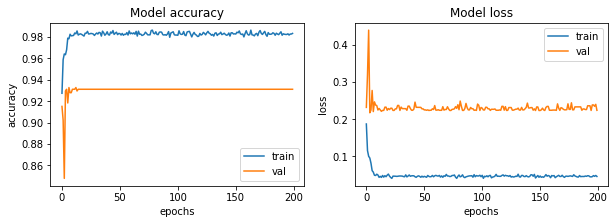

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

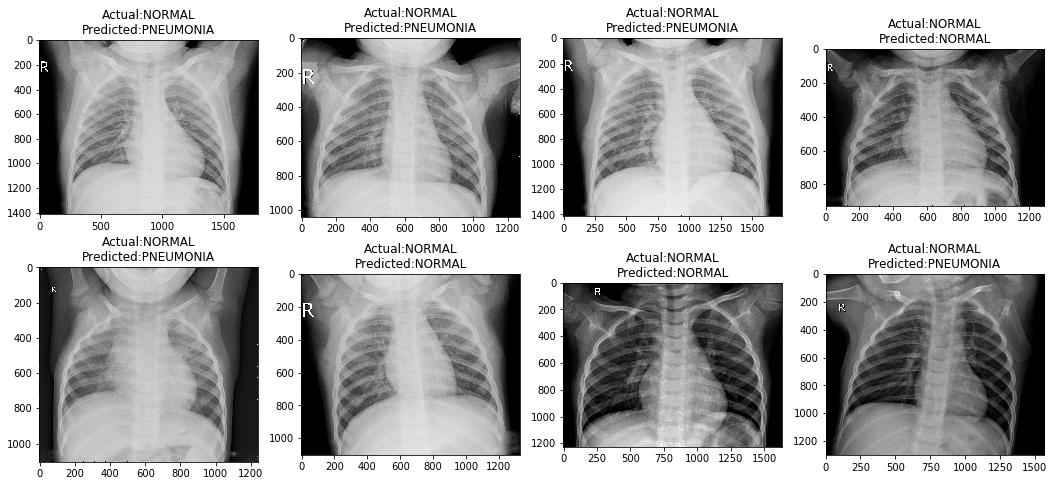

In [31]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

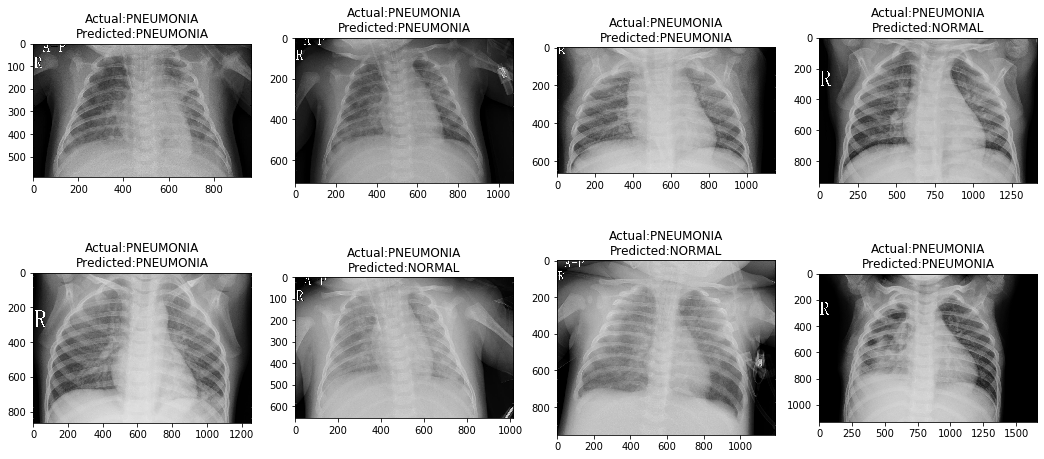

In [32]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

# My Model

In [48]:
model = MyModel()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_99 (Batc (None, 75, 75, 32)        128 

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpoint = ModelCheckpoint(filepath='best_weights_my_model.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

 
model.compile(optimizer=tensorflow.keras.optimizers.Adam(0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 2,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks=[checkpoint, lr_reduce]
)

Epoch 1/2
  6/163 [>.............................] - ETA: 4:25 - loss: 0.6930 - accuracy: 0.6562

KeyboardInterrupt: 

In [36]:
model.save("finalMymodel_final.h5")
print("Saved model to disk")

Saved model to disk


In [37]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 0s 26ms/step - loss: 0.7283 - accuracy: 0.5000
Loss: 0.7282607848756015
Accuracy: 0.5


In [38]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
    y_img_batch, y_true_batch = test_generator[i]
    y_true_batch = y_true_batch.argmax(axis=-1)
    y_img_batches.append(y_img_batch)
    y_true_batches.append(y_true_batch)

    y_pred_batch = model.predict(y_img_batch)
    y_pred_batch = y_pred_batch.argmax(axis=-1)
    y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64)]

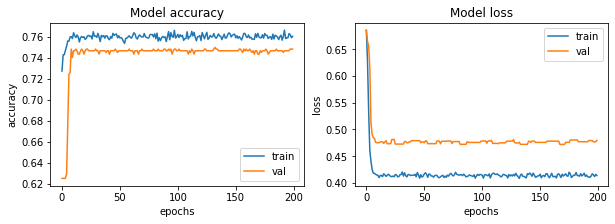

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

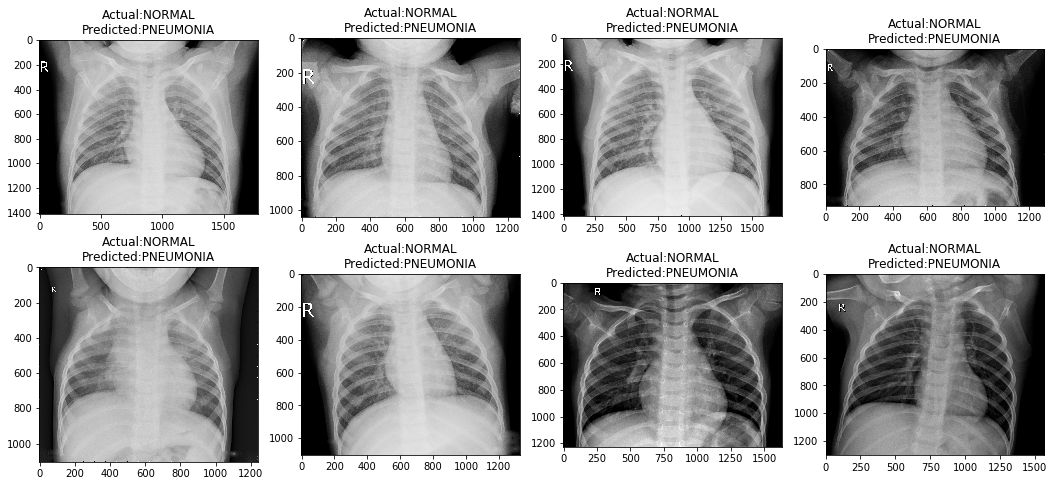

In [40]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

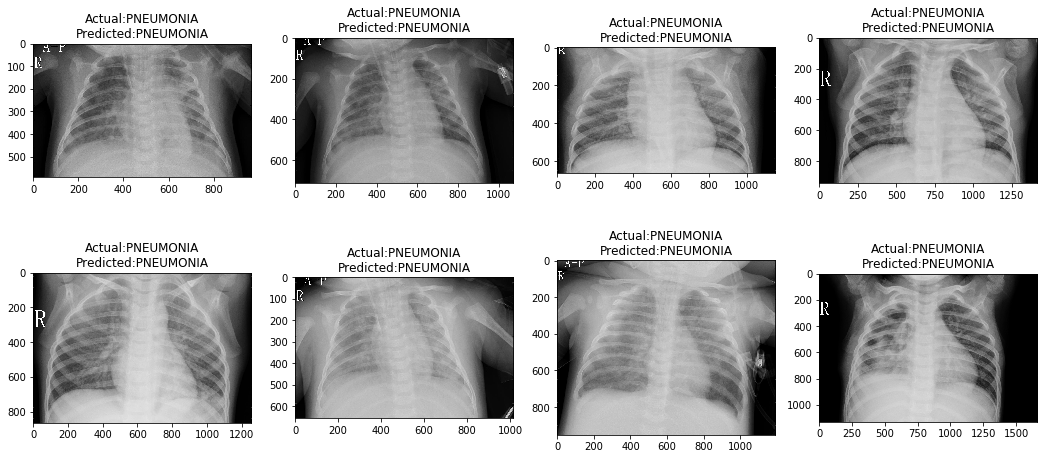

In [41]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

In [43]:
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 5932.